#### From linear classifier to 2 layer Neural Network
> In this section we will walk through an implementation of 2 layers neural network.
we start first by linear classifier which we will extend to a neural network with a few changes

In [4]:
# some setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data driven .. so we need a dataset
> First of all we will generate a dataset to work with we will choose a kind of dataset not linear separable, for instance speral dataset which can be generated with python as follows.

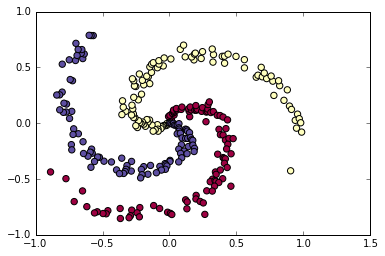

In [5]:
# number of point per class
N = 100
# number of class
K = 3
# dimension of data
D = 2
# data
X = np.zeros((K*N, D))
# labels
y = np.zeros(K*N, dtype='uint8')

# index of classes
for j in range(K):
    ix = range(N*j, N*(j+1))
    y[ix] = j
    radius = np.linspace(0.0, 1, N) # generate a numpy array of size N with values between 0.0 & 1 (linspaced) 
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[radius*np.sin(t), radius*np.cos(t)]
    
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)


#### Training a softmax linear classifier
> 
- As we mentioned above this dataset is not linearly separable
- so it's expected that we get a bad accuracy with a linear classifier, and we will extend it to an ANN  
- The softmax classfier has a linear score function and 
- Use cross-entropy loss function
- The parameters are weights $W$ and bias $b$ for each class (like we have K classifiers in //)

##### Initializing the parameters $W$ and $b$

```python
# initialize the weights and bias
# D : data dimension , K : classes number 
W = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))
```

##### Computing the class scores 

```python
# compute class scores for a linear classifier
scores = np.dot(X, W) + b
```

##### Comuting loss function

In this tutorial we use softmax loss function by using cross-entropy loss of course other choice exist like SVM loss function.

let's take $f$ the score array for a single example (here of size 3, for 3 classes). The softmax loss for this example is as follows : $$L_i = -log( \frac {e^{f_{y_i}} } {\sum_{j} e^{f_j} } ) $$

The full softmax loss is composed from two components loss data and regularization loss

$$L = \frac{1}{N} \sum_i L_i + \frac{1}{2} \beta \sum_k \sum_l W^2_{k,l}$$

Given the scores computed above we can compute the loss

```python
# compute the propablities
# for numerical stabily computation purpose
scores_stable -= np.max(scores, axis=1).reshape(-1, 1) 
exp_scores = np.exp(scores)
normalized_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
```

Since we've normalized them (*normalized_scores*) every row now sums to one. We can now query for the log probabilities assigned to the correct classes in each example:

```python
correct_log_normalized_scores = - np.log(normalized_scores[range(num_examples), y])
```

The array *correct_log_normalized_scores* is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:

```python
data_loss = np.sum(correct_log_normalized_scores) / num_examples
reg_loss = 0.5 * reg * np.sum(W * W)
# total loss
loss = data_loss + reg_loss
```

##### Computing the Analytic Gradient with Backpropagation

Now once the loss is computed we need to minimize it. This can be acheived with the gradient descent (computing the gradient and at each epochs update the parameters in the inverse of the gradient by a step).

$$p_k = \frac{e^{f_k}}{\sum_j e^{f_j}}$$                

$$L_i = -log(p_{y_i})$$

We can prove that (the proof is skiped here)

$$\frac{dL_i}{df_k} = p_k - 1(y_i = k)$$

Assume we compute as normalized probabilities $p = [0.2, 0.3, 0.5]$ and the correct class is that which has index equal to 1 (in the midle) so, $df = [0.2, -0.7, 0.5]$. It's logic as this class is not with the highest score so we need to increase the loss will decrease as gradient is negative for this class.

```python
## compute the gradient on scores function with respect to W and b parameters 
dscores = normalized_scores
dscores[range(num_examples), y] -= 1
dscores /= num_examples
```

Once $dscores$ is computed and as we have $scores = np.dot(X, W) + b$, we can so backpropagate into W and b

```python
# scores = np.dot(X, W) + b here we packpropagate the gradient to the parameters (W, b)
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
# we must not forget this component and the derivative of reg is simple
dW += reg * W 
```

##### Updating the parameters

Now we perform a parameter update in the negative gradient direction to decrease the loss.

```python
# perform a parameter update
W += -step_size * dW
b += -step_size * db
```

### All together

In [35]:
# let's train a linear classifier

# initialize the weights and bias
W = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))

# hyperparameters 
step_size = 1e-0 # gradient step size learning rate
reg = 1e-3 # regularization

num_examples = X.shape[0] # = N * k

# gradient descent loop
for i in xrange(200):
    
    # now we evaluate the scores => matrix [N x K]
    scores = np.dot(X, W) + b
    
    # compute the propablities
    # for numerical stabily computation purpose
    scores_stable -= np.max(scores, axis=1).reshape(-1, 1) 
    exp_scores = np.exp(scores)
    normalized_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # compute the loss = average cross-entrepy loss + regularization
    correct_log_normalized_scores = - np.log(normalized_scores[range(num_examples), y])
    data_loss = np.sum(correct_log_normalized_scores) / num_examples
    reg_loss = 0.5 * reg * np.sum(W * W)
    
    # total loss
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print "iteration %d: loss %f" % (i, loss)
    
    # backpropagation pass
    ## compute the gradient on scores function with respect to W and b parameters 
    dscores = normalized_scores
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    # scores = np.dot(X, W) + b here we packpropagate the gradient to the parameters (W, b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    
    dW += reg * W # we must not forget this component
    
    # gradient descent 
    W += -step_size * dW
    b += -step_size * db
    

iteration 0: loss 1.097114
iteration 10: loss 0.907844
iteration 20: loss 0.837447
iteration 30: loss 0.805472
iteration 40: loss 0.788835
iteration 50: loss 0.779369
iteration 60: loss 0.773640
iteration 70: loss 0.770018
iteration 80: loss 0.767652
iteration 90: loss 0.766068
iteration 100: loss 0.764986
iteration 110: loss 0.764236
iteration 120: loss 0.763709
iteration 130: loss 0.763336
iteration 140: loss 0.763069
iteration 150: loss 0.762877
iteration 160: loss 0.762738
iteration 170: loss 0.762637
iteration 180: loss 0.762563
iteration 190: loss 0.762509


In [33]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.4f%%' % (np.mean(predicted_class == y))

training accuracy: 0.5267%


(-1.8538966913284987, 1.7861033086715046)

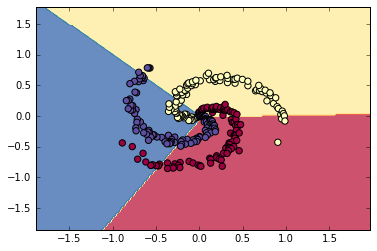

In [34]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

### Training a Neural Network

So, linear classifier is not adapted to this kind of dataset, so we will add on hidden layer to this classfier and by doing so we will get a good accuracy. One note that we will use the ReLU activation function.

#### Initialize parameters & forward pass

```python
# initialize parameters randomly
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))
```

```python
# scores with ReLU activation
hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
```

Scores normalization remain the same as before. In the backpropropagation is as follows

```python
# backpropagate the gradient to the parameters
# we first backpropagate into W2 and b2
# as we have scores = np.dot(hidden_layer, W2) + b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)
```

After that we backpropagate to the hidden layer:

```python
# backpropagate ouver hidden layer
# scores = np.dot(hidden_layer, W2) + b2
dhidden_layer = np.dot(dscores, W2.T)
```
We should pay attention to ReLu as we have $hidden_layer = np.maximum(0, np.dot(X, W1) + b1)$ so we should backprogate the ReLU too:

```python
# backprop the ReLU non-linearity
dhidden_layer[hidden_layer <= 0] = 0
```
 
Now we backpropagate ouver W1, and b1

```python
dW1 = np.dot(X.T, dhidden_layer)
db1 = np.sum(dhidden_layer, axis=0, keepdims=True)
```

And at the end we add reguliralization and we perfom as we did before the parameters update:
```python
# adding regulari
dW2 += reg * W2
dW1 += reg * W1

# gradient descent ==> performing parameters update
W1 += -step_size * dW1
b1 += -step_size * db1
W2 += -step_size * dW2
b2 += -step_size * db2
```

In [56]:
# now let's train a neural network

# hidden layer size
h = 100
W1 = 0.01 * np.random.randn(D, h) # D = 2 here data dimension
b1 = np.zeros((1, h))
W2 = 0.01 * np.random.randn(h, K)
b2 = np.zeros((1, K))

# hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]

for i in xrange(10000):
    
    # scores with ReLU activation
    hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
    scores = np.dot(hidden_layer, W2) + b2
    
    # best practice for numerical stability
    scores_stable = scores
    scores_stable -= np.max(scores_stable, axis=1).reshape(-1, 1) # for numerical stabily computation purpose
    
    # normalize and get probabilities
    exp_scores = np.exp(scores)
    normalized_scores = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    
    # compute the loss function we will use the softmax loss function
    correct_normalized_log = -np.log(normalized_scores[range(num_examples), y])
    data_loss = np.sum(correct_normalized_log) / num_examples
    reg_loss = 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
    
    loss = data_loss + reg_loss
    
    if i % 1000 == 0:
        print "iteration %d: loss %f" % (i, loss)

    # compute the gradient on scores
    dscores = normalized_scores
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    # backpropagate the gradient to the parameters
    # we first backpropagate into W2 and b2
    # as we have scores = np.dot(hidden_layer, W2) + b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    # backpropagate ouver hidden layer
    # scores = np.dot(hidden_layer, W2) + b2
    dhidden_layer = np.dot(dscores, W2.T)

    # backprop the ReLU non-linearity
    # as we have hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
    dhidden_layer[hidden_layer <= 0] = 0
    
    # now we backpropagate ouver W1, and b1
    dW1 = np.dot(X.T, dhidden_layer)
    db1 = np.sum(dhidden_layer, axis=0, keepdims=True)

    # adding regulari
    dW2 += reg * W2
    dW1 += reg * W1
  
    # gradient descent ==> performing parameters update
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2



iteration 0: loss 1.098627
iteration 1000: loss 0.316163
iteration 2000: loss 0.268511
iteration 3000: loss 0.256834
iteration 4000: loss 0.254352
iteration 5000: loss 0.254616
iteration 6000: loss 0.253292
iteration 7000: loss 0.251140
iteration 8000: loss 0.249966
iteration 9000: loss 0.249353


In [58]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.4f' % (np.mean(predicted_class == y))

training accuracy: 0.9867



#### We notice the accuracy is very high compared to linear classifier


(-1.8538966913284987, 1.7861033086715046)

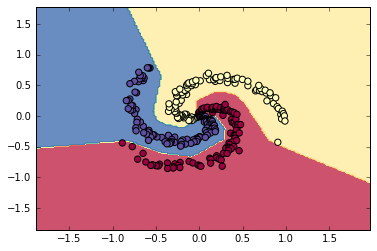

In [60]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())